### Natural Language Processing - Homework 7

Submitted by: Apurv Mittal

Collaborated with Ravi Sivaraman

In [10]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import nltk
from nltk.tag import pos_tag
from pattern.en import parsetree

# Defining function to form the IMDB URL for movie reviews

def get_review_permalink(movieid: str):
    new_url = f'https://www.imdb.com/title/{movieid}/reviews?ref_=tt_urv'
    imdb_data = urllib.request.urlopen(new_url).read().decode("UTF-8")
    soup = BeautifulSoup(imdb_data, "html.parser")
    permalink = []
    for link in soup.find_all('a'):
        a_text = link.text.strip()
        if a_text == "Permalink":
            review_link = link.get('href')
            review_link = "https://imdb.com" + review_link
            permalink.append(review_link)
    return permalink

# Defining function to fetch the review from the URL

def get_review(reviewurl: str):
    review_data = urllib.request.urlopen(reviewurl).read().decode("UTF-8")
    soup = BeautifulSoup(review_data, "html.parser")
    for eachdiv in soup.find_all('div'):
        if eachdiv.has_attr('class'):
            review_body_div_class = ['text', 'show-more__control']
            review_body_div_class.sort()
            divclass = eachdiv['class']
            divclass.sort()
            if review_body_div_class == divclass:
                return (eachdiv.text.strip())

# Reference: https://www.crummy.com/software/BeautifulSoup/bs4/doc/

comedy_movies = ['tt0099088',
                 'tt0099422',
                 'tt0099611',
                 'tt0099785',
                 'tt0099938',
                 'tt0100142',
                 'tt0100405',
                 'tt0100758',
                 'tt0101272',
                 'tt0101587',
                 'tt0101786',
                 'tt0101902',
                 'tt0102032',
                 'tt0102057',
                 'tt0102059',
                 'tt0102492',
                 'tt0102510',
                 'tt0102943',
                 'tt0103060',
                 'tt0103639',
                 'tt0104070',
                 'tt0104694',
                 'tt0104868',
                 'tt0104940',
                 'tt0105121',
                 'tt0105130',
                 'tt0105378',
                 'tt0105399',
                 'tt0105793',
                 'tt0106611',
                 'tt0106941',
                 'tt0107156',
                 'tt0107362',
                 'tt0107614',
                 'tt0107616',
                 'tt0108160',
                 'tt0108327',
                 'tt0108525',
                 'tt0109040',
                 'tt0109190',
                 'tt0109445',
                 'tt0109686',
                 'tt0109707',
                 'tt0109831',
                 'tt0110074',
                 'tt0110099',
                 'tt0110475',
                 'tt0110598',
                 ]

# Chunking and printing the reviews

permalinks_review = []
counter = 1
for each_movie in comedy_movies:
    if counter >500:
        break
    permalinks = get_review_permalink(each_movie)
    for review_url in permalinks:
        review = get_review(review_url)
        permalinks_review.append(review)
        counter += 1
       
                


    

As covered in Homework 5, first we get the reviews from IMDB for comedy movies. We store all the reviews under one variable `permalinks_review`

## Question 1

### k-Means

First method used to the movie reviews is `k-Means`. In order to cluster, first we need to vectorize the text from the reviews.

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(permalinks_review)

To run k-Means, we first need to identify or decide a value of `k`. However, there is no perfect way to know the right value of `k`. To start we will first try to plot Sum of Squared Distance for different values of K to check if there is an elbow. Which can give us a hint on the appropriate value to use.

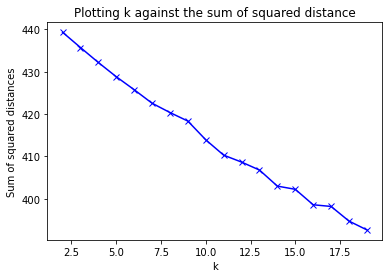

In [12]:
#Find the Elbow to get the Optimal K value

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
   km = KMeans(n_clusters=k, max_iter=200, n_init=10)
   km = km.fit(X)
   Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Plotting k against the sum of squared distance')
plt.show()

# Code Reference: https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

In the above plot there is clear elbow but we can notice an infliction at k=8,12 and 16. We will try these values to check the most appropriate value of k.

### For k=8

#### Reference: https://towardsdatascience.com/clustering-documents-with-python-97314ad6a78d

In [15]:
import pandas as pd
k_val = 8
kmeans = KMeans(n_clusters=k_val, init='k-means++', max_iter=200, n_init=10)
kmeans.fit(X)
labels=kmeans.labels_
review_clustered_df=pd.DataFrame(list(zip(permalinks_review,labels)),columns=['review','cluster'])
print(review_clustered_df.sort_values(by=['cluster']))

                                                review  cluster
407  When a bomb goes off at the offices of Dr Main...        0
357  Jim Abrahams' first solo comedy effort Hot Sho...        0
399  Naked Gun 2½, The (1991) *** (out of 4) Lt. Fr...        0
400  President George H.W. Bush announces that the ...        0
403  Lieutenant Drebin (Leslie Nielsen) discovers t...        0
..                                                 ...      ...
44   Dick Tracy is directed by Warren Beatty and wr...        7
45   This came out with big fanfare in 1990---and d...        7
48   Labor of love for star and director Warren Bea...        7
28   Dick Tracy (1990) ** 1/2 (out of 4) At times b...        7
30   Chisel Chinned Tracy is a unique character in ...        7

[523 rows x 2 columns]


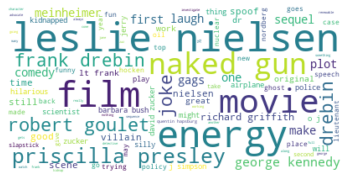

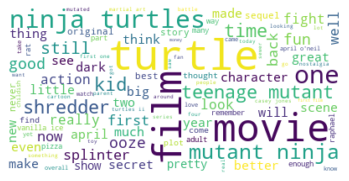

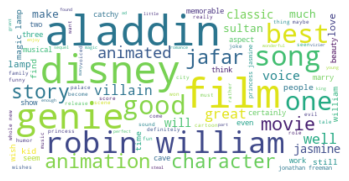

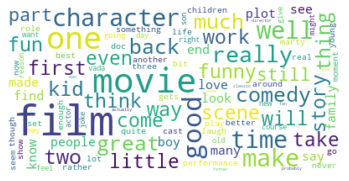

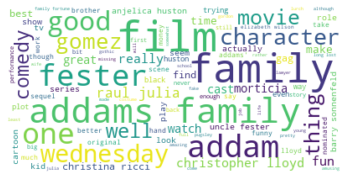

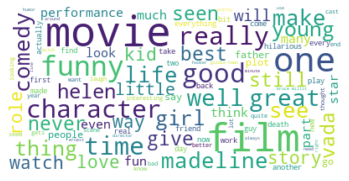

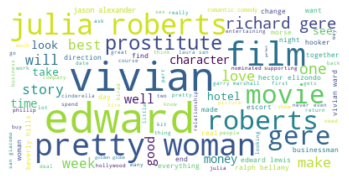

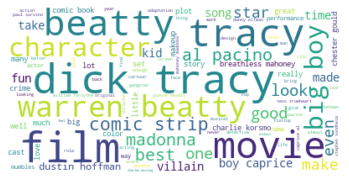

In [24]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(permalinks_review)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'reviews':permalinks_review}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
   s=kmeans_result[kmeans_result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

### For k=12

In [25]:
import pandas as pd
k_val = 12
kmeans = KMeans(n_clusters=k_val, init='k-means++', max_iter=200, n_init=10)
kmeans.fit(X)
labels=kmeans.labels_
review_clustered_df=pd.DataFrame(list(zip(permalinks_review,labels)),columns=['review','cluster'])
print(review_clustered_df.sort_values(by=['cluster']))

                                                review  cluster
317  The One Line Summary says it all.  This movie,...        0
447  One of the most boring and annoying movies I'v...        0
427  Dull and pretentious movie. Pointless unrelate...        0
423  Richard Linklater creates an indie of a day in...        0
114  One of Arnold's best film roles ever. After se...        1
..                                                 ...      ...
492  This movie has three elements that are importa...       11
494  The third out of the box in Disney's animated ...       11
495  A fantastic animated film from Disney's early-...       11
497  To be honest, even as a kid I didn't really li...       11
476  This is part of the Disney winning streak of w...       11

[523 rows x 2 columns]


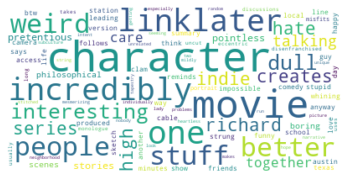

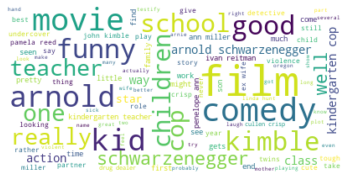

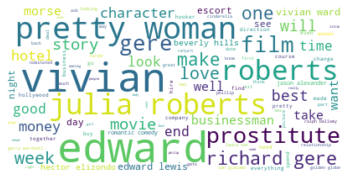

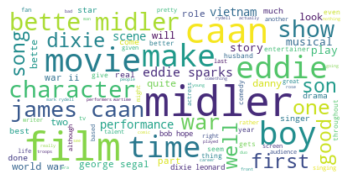

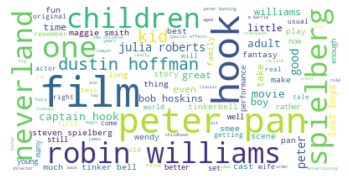

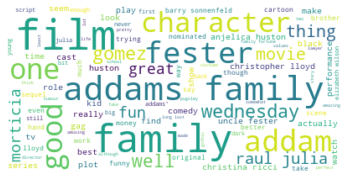

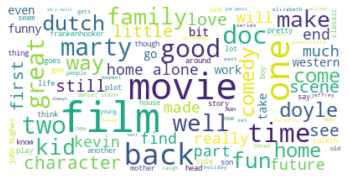

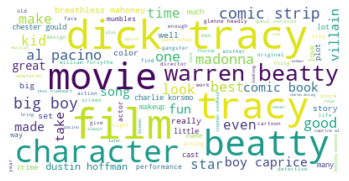

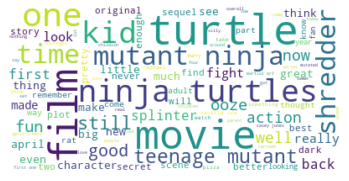

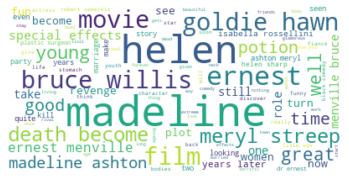

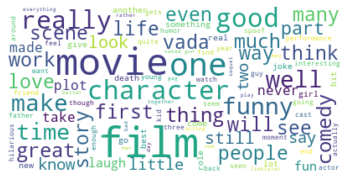

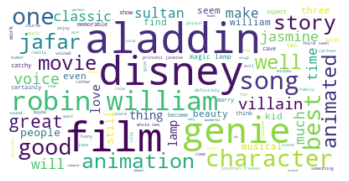

In [26]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(permalinks_review)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'reviews':permalinks_review}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
   s=kmeans_result[kmeans_result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

### For k=16

In [27]:
import pandas as pd
k_val = 16
kmeans = KMeans(n_clusters=k_val, init='k-means++', max_iter=200, n_init=10)
kmeans.fit(X)
labels=kmeans.labels_
review_clustered_df=pd.DataFrame(list(zip(permalinks_review,labels)),columns=['review','cluster'])
print(review_clustered_df.sort_values(by=['cluster']))

                                                review  cluster
492  This movie has three elements that are importa...        0
497  To be honest, even as a kid I didn't really li...        0
495  A fantastic animated film from Disney's early-...        0
494  The third out of the box in Disney's animated ...        0
491  Aladdin is a poor yet care-free street urchin ...        0
..                                                 ...      ...
383  Vada is obsessed with death. Her mother is dea...       15
388  In the early 00's as a young boy I woke up to ...       15
380  1972. Vada Sultenfuss (played by Anna Chlumsky...       15
387  "My Girl" is a very good coming-of-age story t...       15
391  MY GIRL, in my opinion, is a very touching and...       15

[523 rows x 2 columns]


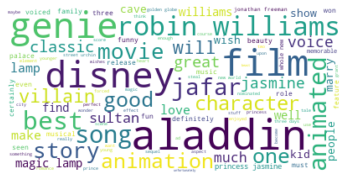

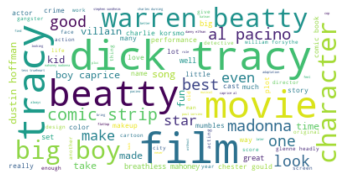

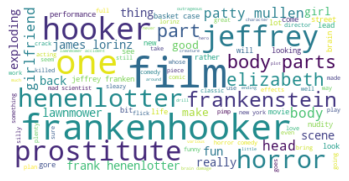

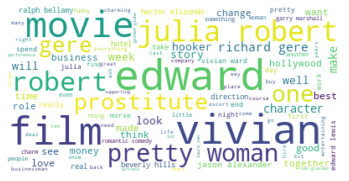

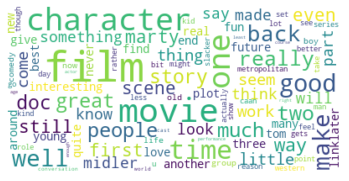

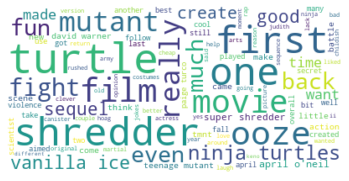

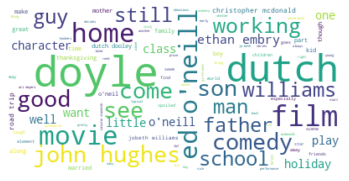

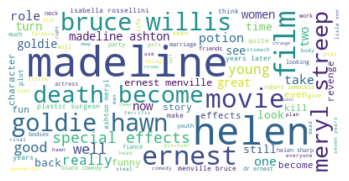

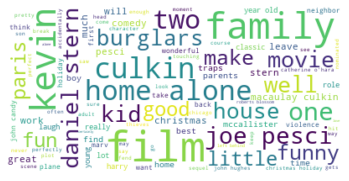

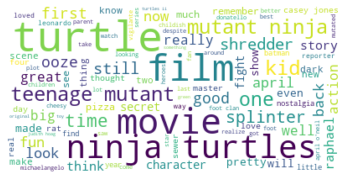

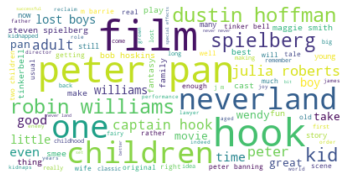

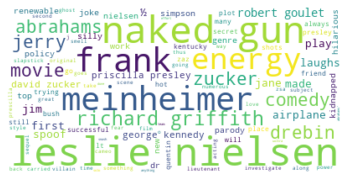

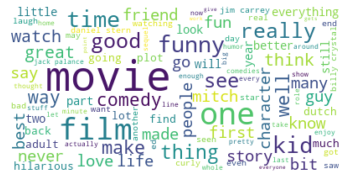

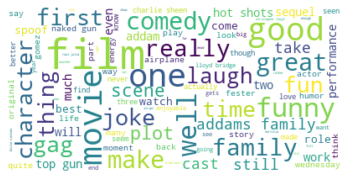

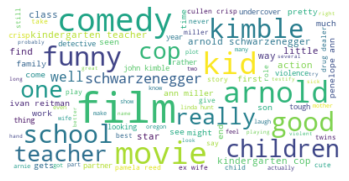

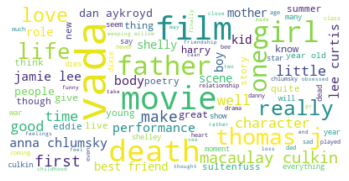

In [28]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words={'english'})
X = vectorizer.fit_transform(permalinks_review)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'reviews':permalinks_review}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
   s=kmeans_result[kmeans_result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

### Agglomerative Clustering

#### Reference: http://brandonrose.org/clustering

In [29]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
agglo_cluster = AgglomerativeClustering(n_clusters=17, affinity='euclidean').fit(X.toarray())

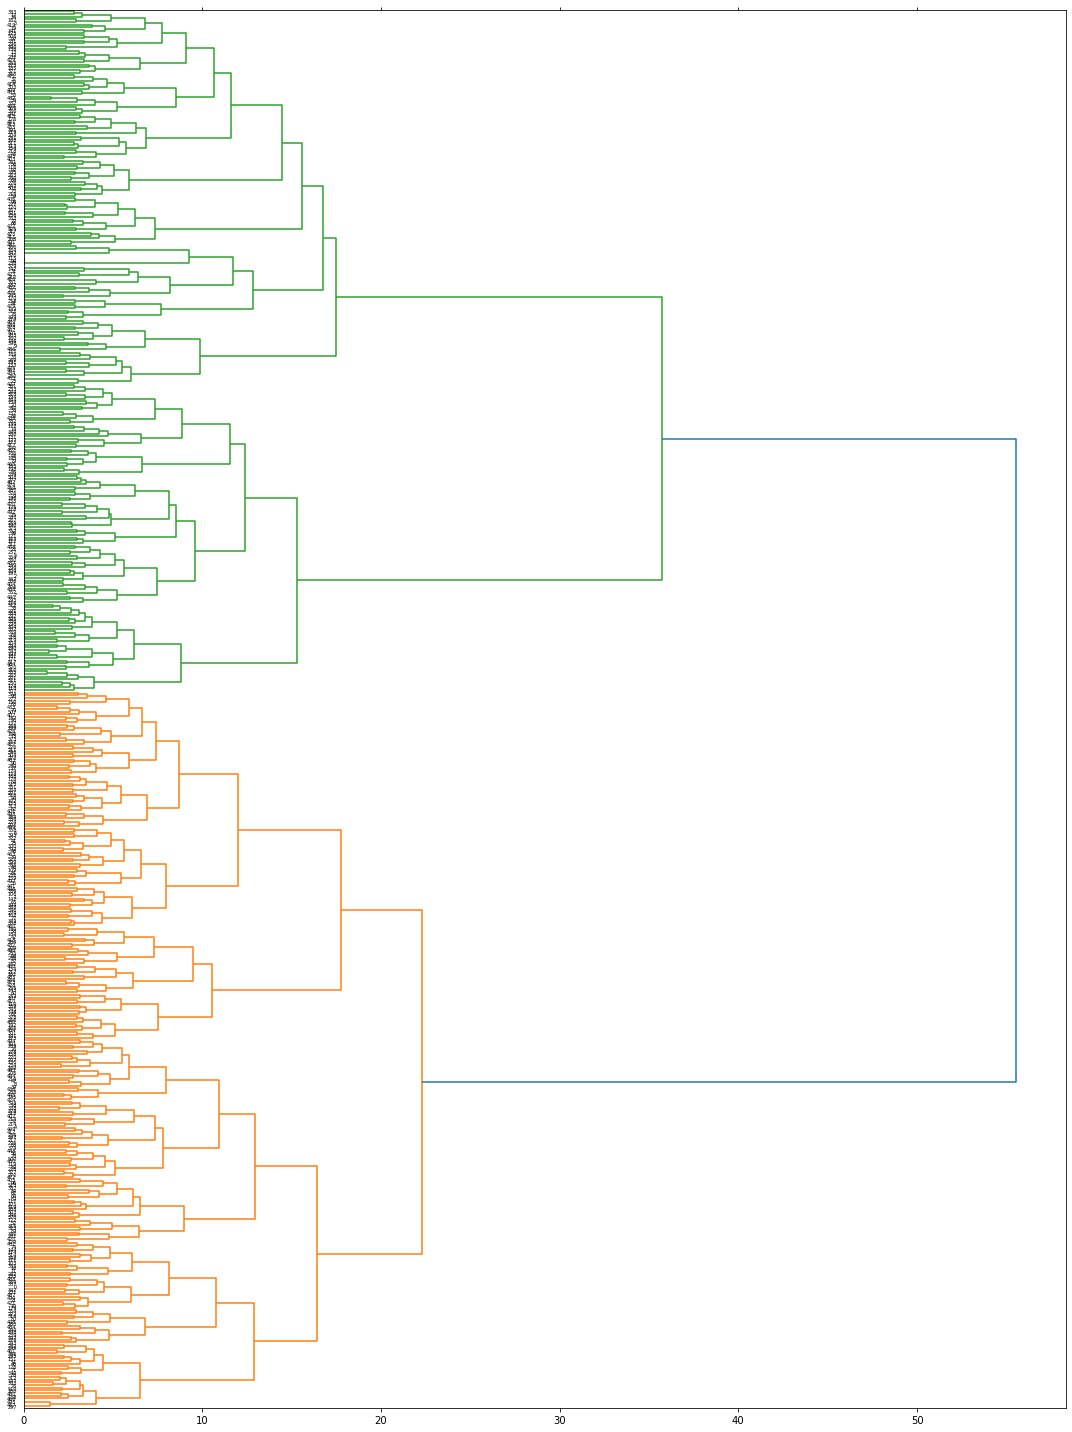

In [35]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(permalinks_review)
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

Above dendogram shows the hierarchical clustering where all the reviews are clustered to their own individual cluster. This is not very helpful. So, we need to first define the value at which we want to truncate (cut) the dendogram. 

### At p=8

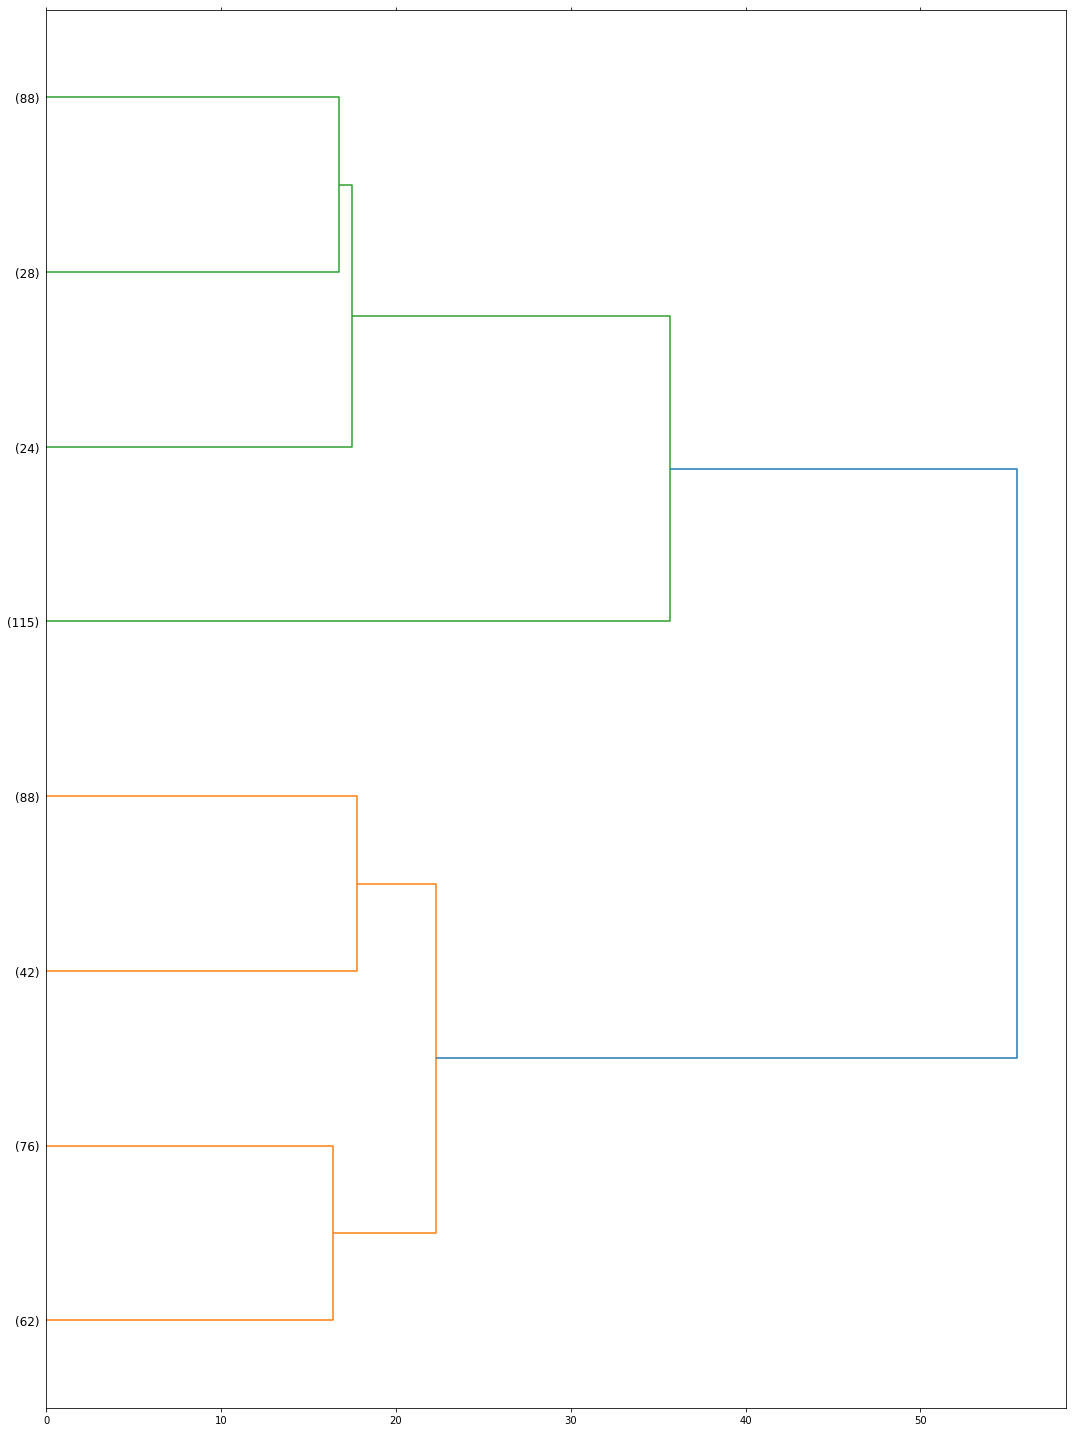

In [37]:

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", truncate_mode='lastp', p=8);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

### At p=12

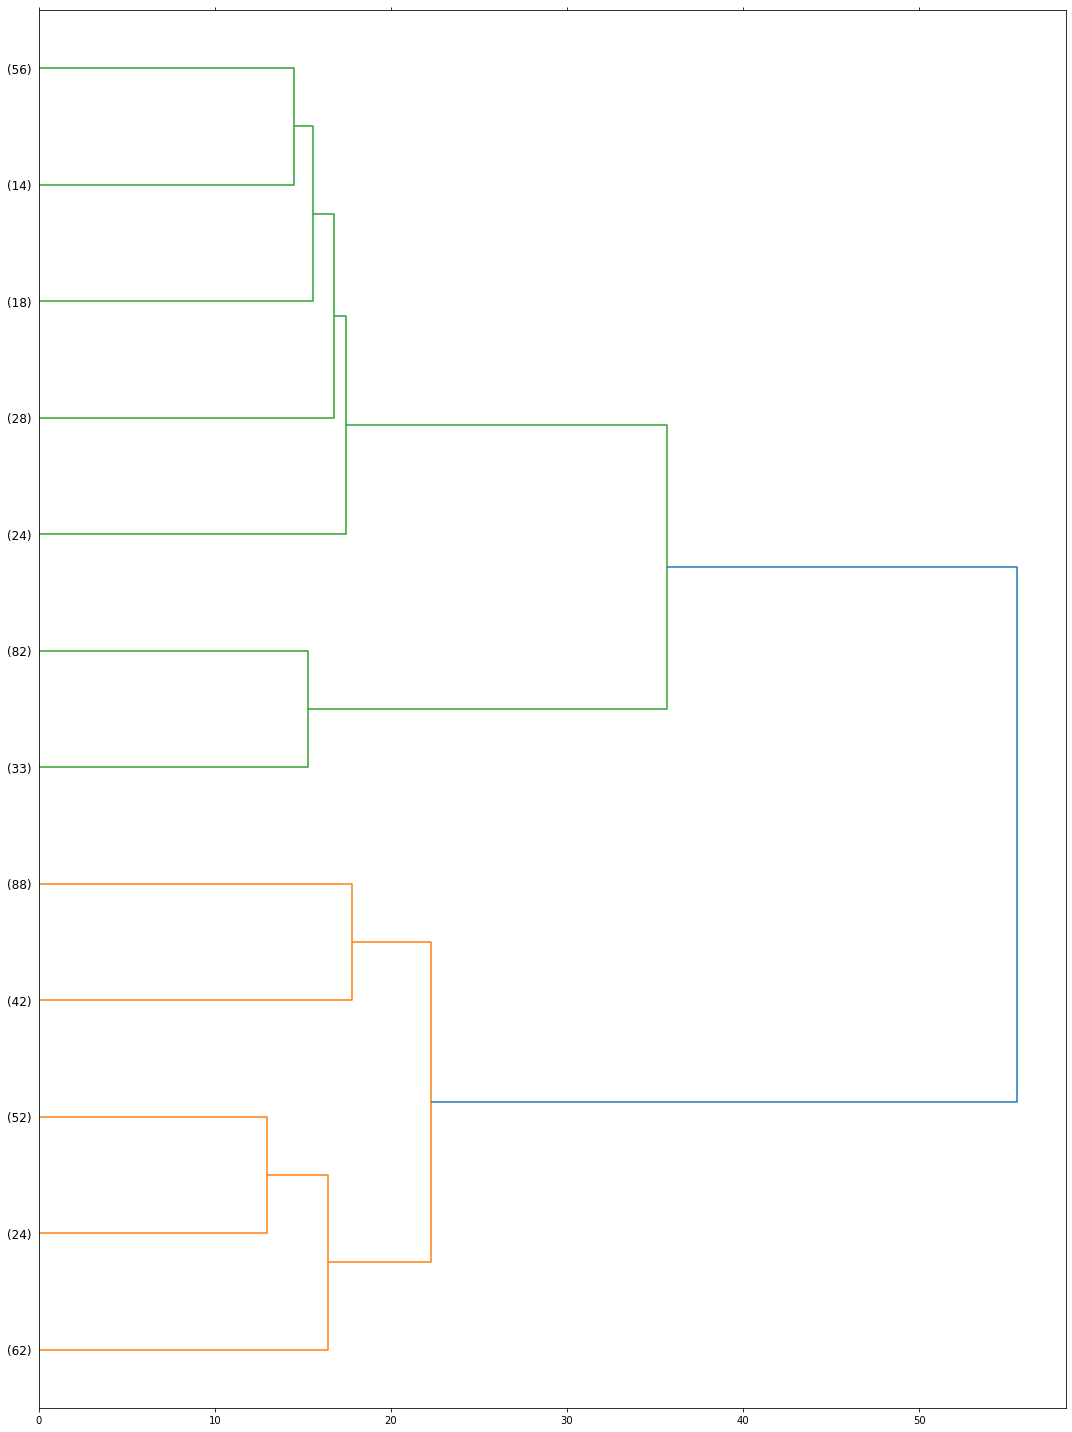

In [40]:

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", truncate_mode='lastp', p=12);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

### At p=16

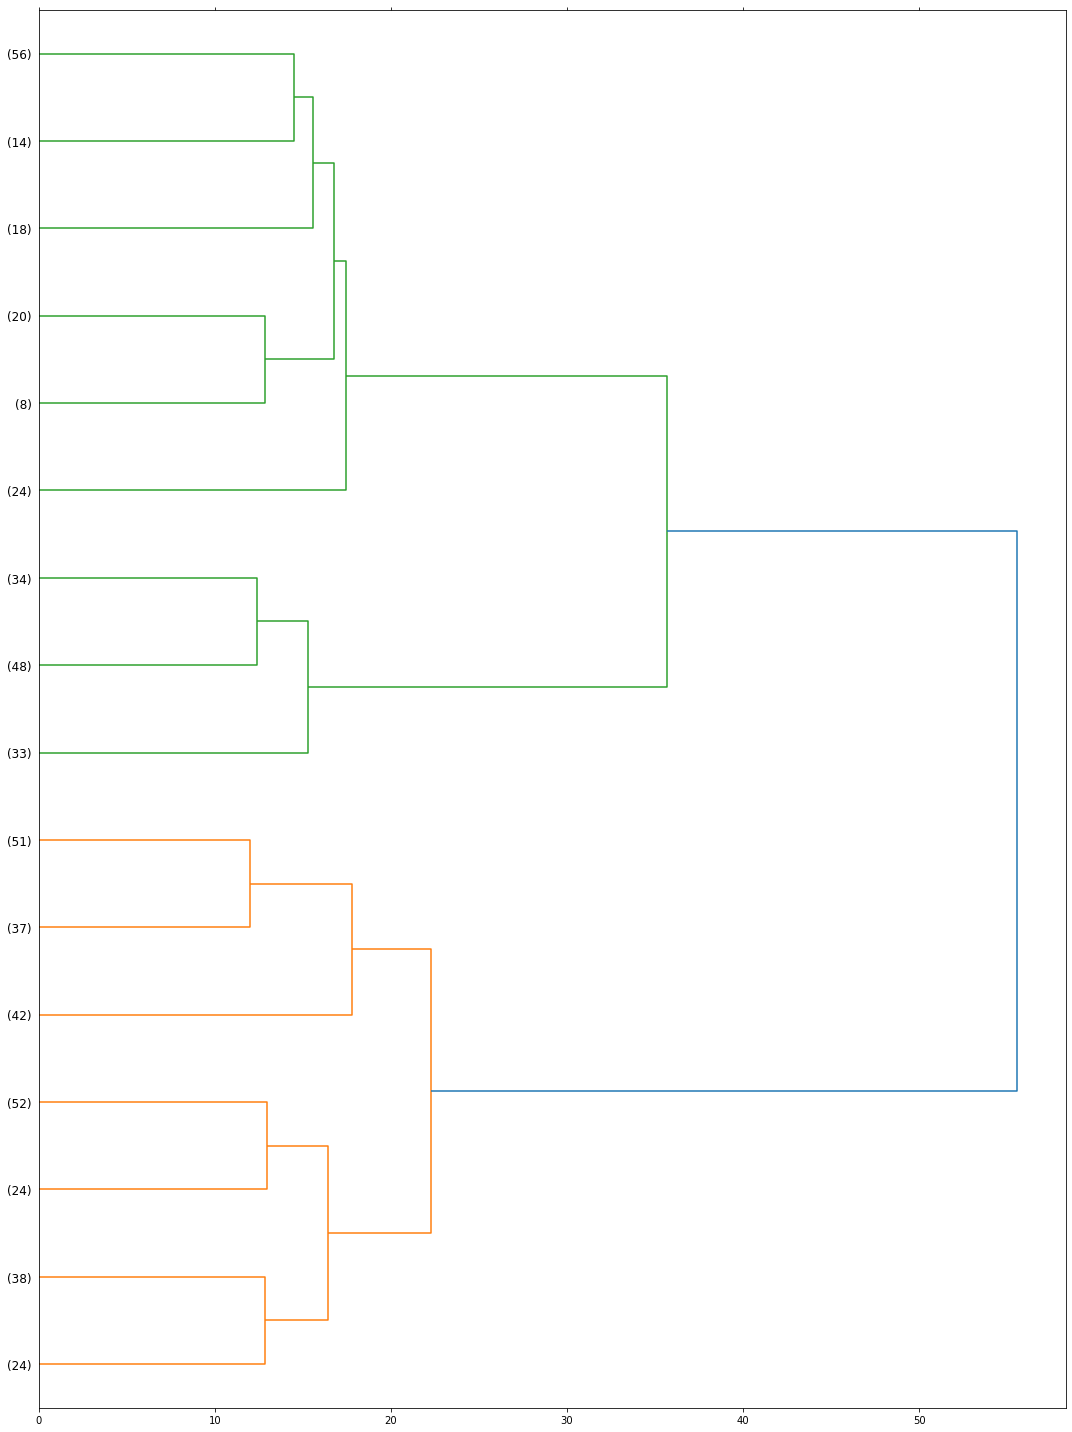

In [50]:

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", truncate_mode='lastp', p=16);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

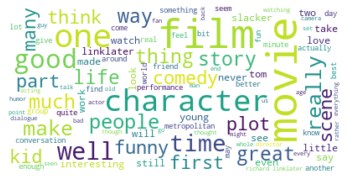

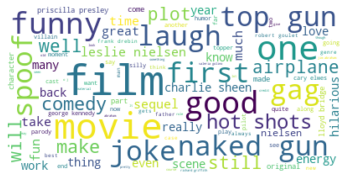

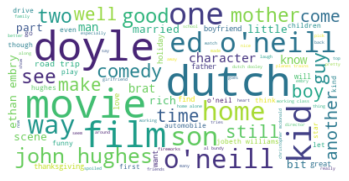

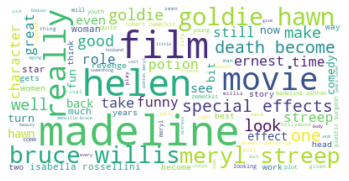

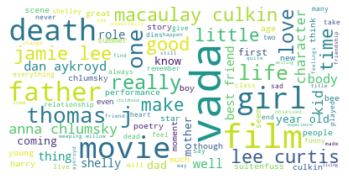

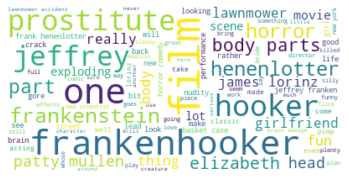

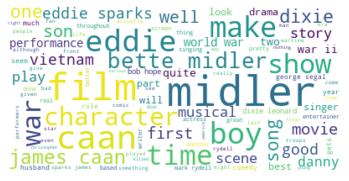

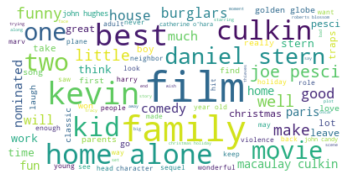

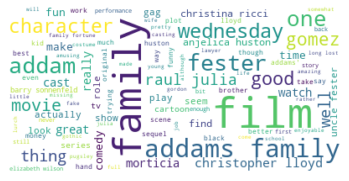

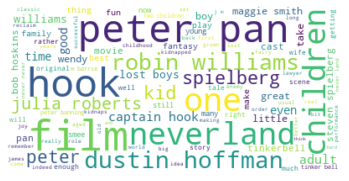

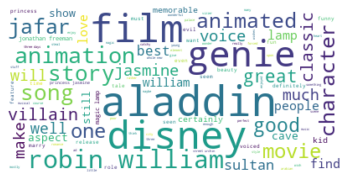

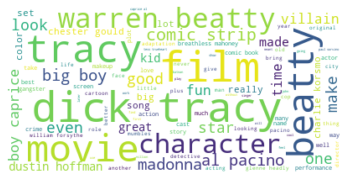

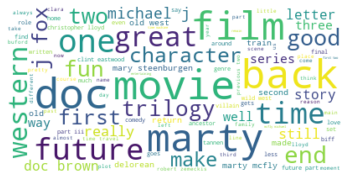

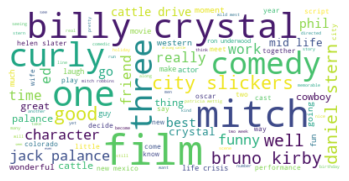

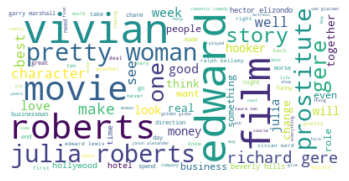

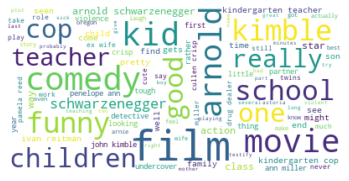

In [51]:
labels = agglo_cluster.labels_
cluster_size = 16
from wordcloud import WordCloud
result={'cluster':labels,'reviews':permalinks_review}
result=pd.DataFrame(result)
for k in range(0,cluster_size):
   s=result[result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()

## Question 2

From the above clustering and visual depiction using wordcloud, we can see how the clusters are formed. In case of k-Means clusters the words which are closely associated with each other and more often together in a review are formed into a cluster. For example: words like `Disney`, `Alladin`, `Sultan` are part of one cluster which makes sense as they all are disney movie characters. Similarly `Children`, `Hook`, `Peter Pan`, `Neverland` are all in same cluster for their close association to each other. We can label the clusters based on some of these words. However, its not always clear why some words are on a cluster vs others. For example: `Robin Williams` is on multiple clusters and its makes sense for it to be on multiple clusters however, its harder to label the cluters based on such duplicate words. Also, knowing the correct value of `k` is a challenge and preference of the analyst of how many cluster to keep.

In case of hierarchical clustering, all reviews are clustered on its own and as an analyst one can decide how many clusters they would like and decide to cut the dendogram accordingly. The leaves of the denodogram depict how many reviews are in each cluster. The best way to visualize is to print the wordcloud again for the clusters and try to make sense out of it. Though its not always clear why certain words are in a cluster and what infrences can be made for the cluster. For example: multiple clusters with references to `Teenage Mutant Ninja Turtles`.Its not justa duplicate words but more of an issue with accuracy of clusters and how can we reduce the changes of ambigous clustering.

## Question 3

In order to decide which clustering technique is better, we can calculate the `Entropy` for both the clusters. We will use 16 clusters for comparision of both the techniques.

#### Entropy of k-Means

In order to calculate Entropy we need to first determine the `p` value.

In [52]:
from scipy.stats import entropy
clusters = list(kmeans.labels_)
total_c = len(clusters)
p_of_i = []
for eachpos in clusters:
     p_of_i.append(clusters.count(eachpos)/total_c )

entropy_cluster = entropy(p_of_i)
print("K-Means Entropy", entropy_cluster)

K-Means Entropy 6.022633373674839


#### Entropy of Agglomerative Clustering

In [53]:
clusters = list(agglo_cluster.labels_)
total_c = len(clusters)
p_of_i = []
for eachpos in clusters:
     p_of_i.append(clusters.count(eachpos)/total_c )

entropy_cluster = entropy(p_of_i)
print("Agglomerative Entropy", entropy_cluster)

Agglomerative Entropy 5.86762446396283


Since lower the value of Entropy better the clustering. Based on that we can say Agglomerative Clustering results are slightly better than that of the k-Means.

#### -End of Homework 7-